<a href="https://colab.research.google.com/github/YichenGao/Fractory/blob/main/6_7960_Deep_Learning_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIT 6.7960 Fall 2024 PyTorch Tutorial:

This colab is adapted from both https://github.com/davidbau/how-to-read-pytorch and https://pytorch.org/tutorials/beginner/basics/intro.html, which are great resources if you’re interested in learning more.



Pytorch and its key features
===================

Pytorch is a numerical library that makes it very convenient to train deep networks on GPU hardware. It introduces a new programming vocabulary that takes a few steps beyond regular numerical python code. Although pytorch code can look simple and concrete, much of of the subtlety of what happens is invisible, so when working with pytorch code it helps to thoroughly understand the runtime model.

For example, consider this code:

```
torch.nn.cross_entropy(model(images.cuda()), labels.cuda()).backward()
optimizer.step()
```

It looks like it computes some function of `images` and `labels` without storing the answer.  But actually the purpose of this code is to update some hidden parameters that are not explicit in this formula.  This line of code moves batches of image and label data from CPU to the GPU; runs a neural network to make a prediction; constructs a computation graph describing how the loss depends on the network parameters; annotates every network parameter with a gradient; then finally it runs one step of optimization to adjust every parameter of the model.  During all this, the CPU does not see any of the actual answers.  That is intentional for speed reasons.  All the numerical computation is done on the GPU asynchronously and kept there.

The brevity of the code is what makes pytorch code fun to write.  But it also reflects why pytorch can be so fast even though the python interpreter is so slow. Although the main python logic slogs along sequentially in a single very slow CPU thread, just a few python instructions can load a huge amount of work into the GPU.  That means the program can keep the GPU busy churning through massive numerical computations, for most part, without waiting for the python interpreter.

It is worth understanding five core idioms that work together to make this possible.  This tutorial covers five Colab notebooks, one for each topic:

 1. [GPU Tensor arithmetic](https://colab.research.google.com/github/davidbau/how-to-read-pytorch/blob/master/notebooks/1-Pytorch-Introduction.ipynb): the notation for manipulating n-dimensional arrays of numbers on CPU or GPU.
 2. [Autograd](https://colab.research.google.com/github/davidbau/how-to-read-pytorch/blob/master/notebooks//2-Pytorch-Autograd.ipynb): how to build a tensor computation graph and use it to get derivatives of any scalar with respect to any input.
 3. [Optimization](https://colab.research.google.com/github/davidbau/how-to-read-pytorch/blob/master/notebooks//3-Pytorch-Optimizers.ipynb): ways to update tensor parameters to reduce any computed objective, using autograd gradients.
 4. [Network modules](https://colab.research.google.com/github/davidbau/how-to-read-pytorch/blob/master/notebooks//4-Pytorch-Modules.ipynb): how pytorch represents neural networks for convenient composition, training, and saving.
 5. [Datasets and Dataloaders](https://colab.research.google.com/github/davidbau/how-to-read-pytorch/blob/master/notebooks//5-Pytorch-Dataloader.ipynb): for efficient multithreaded prefetching of large streams of data.

The key ideas are illustrated with small, illustrated, hackable examples, and there are links to other reference material and resources.

All the notebooks can be run on Google Colab where some GPU compuation can be used for free, or they can be run on your own local Jupyter notebook server.

The examples should all work with python 3.5 or newer and pytorch 1.0 or newer.

The original code on github can be found [here](https://github.com/davidbau/how-to-read-pytorch).

In [ ]:
import math
import numpy as np
import torch
from matplotlib import pyplot as plt

Topic 1: Pytorch Tensors
===============

The first big trick for doing math fast on a modern computer is to do giant array operations all at once.

To faciliate this, pytorch provides a [`torch.Tensor`](https://pytorch.org/docs/stable/tensors.html) class that is a lookalike to the older python numerical library [`numpy.ndarray`](https://numpy.org/doc/1.18/reference/arrays.ndarray.html).  Just like a numpy `ndarray`, the pytorch `Tensor` stores a d-dimensional array of numbers, where d can be zero or more, and where the contained numbers can be any of the usual selection of float or integer types.  Pytorch is designed to feel just like numpy: almost all the numpy operations are also available on torch tensors. But if something is missing, torch tensors can be directly converted to and from numpy using `x.numpy()` and `torch.from_numpy(a)`. So what is different and why did the pytorch authors bother to reimplement this whole library?

**There are two things that pytorch Tensors have that numpy arrays lack:**

 1. pytorch Tensors can live on either **GPU or CPU** (numpy is cpu-only).
 2. pytorch can automatically track tensor computations to enable **automatic differentiation**.

In the following sections on this page we talk about the basics of the Tensor API as well as point (1) - how to work with GPU and CPU tensors.  A discussion of (2) can be found in the next notebook, [2. Autograd](https://colab.research.google.com/github/davidbau/pytorch-tutorial/blob/master/notebooks/2-Pytorch-Autograd.ipynb).


Initializing a Tensor
=====================

Tensors can be initialized in various ways. Take a look at the following
examples:

**Directly from data**

Tensors can be created directly from data. The data type is
automatically inferred.


In [ ]:
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)
print(x_data)

tensor([[1, 2],
        [3, 4]])


**From a NumPy array**

Tensors can be created from NumPy arrays and vice versa - see [Bridge with NumPy](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#bridge-to-np-label).


In [ ]:
np_array = np.array(data)
x_np = torch.from_numpy(np_array)
print(x_np)

tensor([[1, 2],
        [3, 4]])


**From another tensor:**

The new tensor retains the properties (shape, datatype) of the argument
tensor, unless explicitly overridden.


In [ ]:
x_ones = torch.ones_like(x_data) # retains the properties of x_data
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides the datatype of x_data
print(f"Random Tensor: \n {x_rand} \n")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.1636, 0.6457],
        [0.7739, 0.2257]]) 



**With random or constant values:**

`shape` is a tuple of tensor dimensions. In the functions below, it
determines the dimensionality of the output tensor.


In [ ]:
shape = (2,3)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

Random Tensor: 
 tensor([[0.7034, 0.4629, 0.3967],
        [0.7860, 0.1314, 0.2735]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


------------------------------------------------------------------------


Attributes of a Tensor
======================

Tensor attributes describe their shape, datatype, and the device on
which they are stored.


In [ ]:
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


Basic operations in the Tensor API
----------------------------------

Pytorch is not very different from numpy, although the pytorch API has more convenience methods such as `x.clamp(0).pow(2)` (supporting a chained method style, as is popular in Javascript libraries, so you don't need to say the verbose `numpy.clip(numpy.pow(x, 2), 0)`). So code is often shorter in pytorch.  A brief overview:

**Elementwise operations.** Most tensor operations are simple (embarassingly parallelizable) elementwise operations, where the same math is done on every element of the array.  `x+y`, `x*y`, `x.abs()`, `x.pow(3)`, etc.  Unlike Matlab, `*` is for element-wise multiplication, not matrix-multiplication.

**Copy semantics by default.** Almost all operations, including things like `x.sort()`, return a new copy of the tensor without overwriting the input tensors.  The exceptions are functions that end in an underscore such as `x.mul_(2)` which doubles the contents of x in-place.

**Common reduction operations.**  There are some common operations such as `max`, `min`, `mean`, `sum` that reduce the array by one or more dimension. In pytorch, you can specify which dimension you want to reduce by passing the argument `dim=n`.

**Why does min return two things?** Note that `[data, indexes] = x.sort(dim=0)` and `[vals, indexes] = x.min(dim=0)` return the pair of both the answer and the index values, so you do not need to separately recompute `argsort` or `argmin` when you need to know where the min came from.

**What about linear algebra?** It's there.  `torch.mm(a,b)` is matrix multiplication, `torch.inverse(a)` inverts, `torch.eig(a)` gets eigenvalues, etc.

The other thing to know is that pytorch tends to be very fast, often much faster than numpy even on CPU, because its implementation is aggressively parallelized behind-the-scenes.  Pytorch is willing to use multiple threads in situations where numpy just uses one.

See the [reference for Tensor methods](https://pytorch.org/docs/stable/tensors.html#torch.Tensor) for what comes built-in.  A simple demo of some vectors:



In [ ]:
# Make a vector of 101 equally spaced numbers from 0 to 5.
x = torch.linspace(0, 5, 101)

# Print the first five things in x.
print(x[:5])

tensor([0.0000, 0.0500, 0.1000, 0.1500, 0.2000])


### Exercise

Print the last five things in x.

In [ ]:
# Todo: Print the last five things in x (instead of the first five)

print(x[-5:])

tensor([4.8000, 4.8500, 4.9000, 4.9500, 5.0000])


The shape of x is torch.Size([101])
The shape of y1=x.sin() is torch.Size([101])
The shape of y2=x ** x.cos() is torch.Size([101])
The shape of y3=y2 - y1 is torch.Size([101])
The shape of y4=y3.min() is torch.Size([]), a zero-d scalar


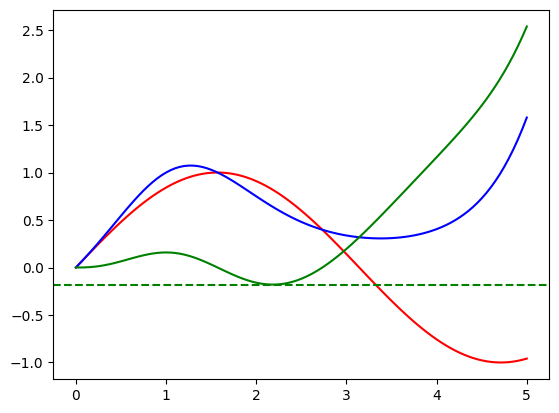

In [ ]:
# Do some vector computations.
y1, y2 = x.sin(), x ** x.cos()
y3 = y2 - y1
y4 = y3.min()

# Print and plot some answers.
print(f'The shape of x is {x.shape}')
print(f'The shape of y1=x.sin() is {y1.shape}')
print(f'The shape of y2=x ** x.cos() is {y2.shape}')
print(f'The shape of y3=y2 - y1 is {y3.shape}')
print(f'The shape of y4=y3.min() is {y4.shape}, a zero-d scalar')

plt.plot(x, y1, 'red', x, y2, 'blue', x, y3, 'green')
plt.axhline(y4, color='green', linestyle='--')
plt.show()

### Exercise

Plot y3 clamped between 0.0 and 1.0.

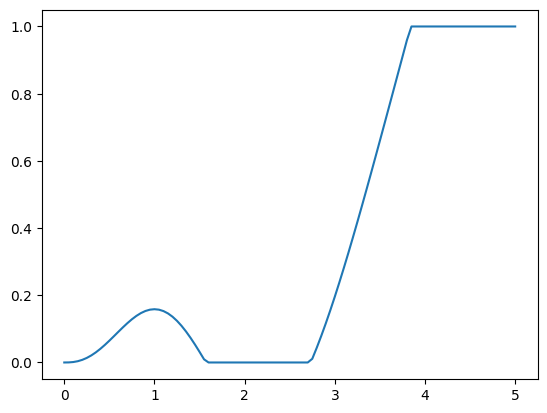

In [ ]:
# Todo: Plot y3 clamped between 0.0 and 1.0.

y4 = y3.clamp(0,1)

plt.plot(x,y4)
plt.show()


pytorch Tensor dimension-ordering conventions
---------------------------------------------

**Multidimensional data convention.** As soon as you have more than one dimension, you need to decide how to order the axes.  To reduce confusion, most data processing follows the same global convention. In particular, much image-related data in pytorch is four dimensional, and the dimensions are ordered like this: `data[batch_index, channel_index, y_position, x_position]`, that is:

* Dimension 0 is used to index separate images within a batch.
* Dimension 1 indexes channels within an image representation (e.g., 0,1,2 = R,G,B, or more dims for more channels).
* Dimension 2 (if present) indexes the row position (y-value, starting from the top)
* Dimension 3 (if present) indexes the column position (x-value, starting from the left)

There a way to remember this ordering: adjacent entries that vary only in the last dimensions are stored physically closer in RAM; since they are often combined with each other, this could help with locality, whereas the first (batch) dimension usually just groups separate independent data points which are not combined much, so they do not need to be physically close.

Stream-oriented data without grid geometry will drop the last dimensions, and 3d grid data will be 5-dimensional, adding a depth z before y.  This same 4d-axis ordering convention is also seen in caffe and tensorflow.

Separate tensors can be put together into a single batch tensor using `torch.cat([a, b, c])` or `torch.stack([a, b, c])`.  (The difference: `cat` doesn't add any new dimensions but just concatenates along the existing 0th dimension.  `stack` adds a new 0th dimension for the batch.)

**Multidimensional linear operation convention.** When storing matrix weights or convolution weights, linear algebra conventions are followed
* Dimension 0 (number of rows) matches the output channel dimension
* Dimension 1 (number of columns) matches the input channel dimension
* Dimension 2 (if present) is the convolutional kernel y-dimension
* Dimension 3 (if present) is the convolutional kernel x-dimension

Since this convention assumes channels are arranged in different rows whereas the data convention puts different batch items in different rows, some axis transposition is often needed before applying linear algebra to the data.

**Permute and view reshape an array without moving memory.** The `permute` and `view` methods are useful for rearranging, flattening, and unflatteneing axes. `x.permute(1,0,2,3).view(x.shape[1], -1)`.  They just alter the view of the block of numbers in memory without moving any of the numbers around, so they are fast.

**Reshaping sometimes needs copying.** Some sequences of axis permutations and flattenings cannot be done without copying the data into the new order in memory; the `x.contiguous()` method copies the data iinto the natural order given by the current view; also `x.reshape()` is similar to `view` but will makea copy if necessary so you do not need to think about it.  See [the Tensor.view method documentation](https://pytorch.org/docs/master/tensors.html#torch.Tensor.view).


### Exercise

Use `torch.randn` to create a four-dimensional tensor `x` of size (2,3,4,5), which could store two 5x4 RGB images.

Then print three things:
 * print `x`.
 * Use `x.permute` to switch the horizontal and vertical (last two) dimensions.
 * Use `x.view` to see each image as a flat vector of 60 numbers.

In [ ]:
# TODO make x of size (2,3,4,5), and print three rearrangements of x
x = torch.rand((2,3,4,5))
print(x.shape)

# Permute dimensions
print(x.permute((0,1,3,2)).shape)

# Reshape
print(x.view(x.shape[0],-1).shape)

torch.Size([2, 3, 4, 5])
torch.Size([2, 3, 5, 4])
torch.Size([2, 60])


**Standard numpy-like indexing and slicing:**


In [ ]:
tensor = torch.ones(4, 4)
print(f"First row: {tensor[0]}")
print(f"First column: {tensor[:, 0]}")
print(f"Last column: {tensor[:, -1]}")
tensor[:,1] = 0
print(tensor)

First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


**Joining tensors** You can use `torch.cat` to concatenate a sequence of
tensors along a given dimension. See also
[torch.stack](https://pytorch.org/docs/stable/generated/torch.stack.html),
another tensor joining operator that is subtly different from
`torch.cat`.


In [ ]:
t1 = torch.cat([tensor, tensor, tensor], dim=0) # Concatanates along dimension
print(tensor)
print(tensor.shape)
print(t1)
print(t1.shape)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])
torch.Size([4, 4])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])
torch.Size([12, 4])


In [ ]:
t2 = torch.stack([tensor, tensor, tensor], dim=1) # Creates new dimension
print(tensor)
print(tensor.shape)
print(t2)
print(t2.shape)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])
torch.Size([4, 4])
tensor([[[1., 0., 1., 1.],
         [1., 0., 1., 1.],
         [1., 0., 1., 1.]],

        [[1., 0., 1., 1.],
         [1., 0., 1., 1.],
         [1., 0., 1., 1.]],

        [[1., 0., 1., 1.],
         [1., 0., 1., 1.],
         [1., 0., 1., 1.]],

        [[1., 0., 1., 1.],
         [1., 0., 1., 1.],
         [1., 0., 1., 1.]]])
torch.Size([4, 3, 4])


**Empty Dimensions**

In [ ]:
t3 = tensor.unsqueeze(0)
print(tensor.shape)
print(t3.shape)
print(t3)
t4 = t3.squeeze(0)
print(tensor.shape)
print(t4.shape)
print(t4)


torch.Size([4, 4])
torch.Size([1, 4, 4])
tensor([[[1., 0., 1., 1.],
         [1., 0., 1., 1.],
         [1., 0., 1., 1.],
         [1., 0., 1., 1.]]])
torch.Size([4, 4])
torch.Size([4, 4])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


**Arithmetic operations**


In [ ]:
# This computes the matrix multiplication between two tensors. y1, y2, y3 will have the same value
# ``tensor.T`` returns the transpose of a tensor
tensor = torch.Tensor([[1,2,5],[3,4,6]])
print(tensor.shape)

y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)
y3 = torch.rand_like(y1)
torch.matmul(tensor, tensor.T, out=y3)
print(y1, y1.shape)
print(y2, y2.shape)
print(y3, y3.shape)


torch.Size([2, 3])
tensor([[30., 41.],
        [41., 61.]]) torch.Size([2, 2])
tensor([[30., 41.],
        [41., 61.]]) torch.Size([2, 2])
tensor([[30., 41.],
        [41., 61.]]) torch.Size([2, 2])


In [ ]:
# This computes the element-wise product. z1, z2, z3 will have the same value
z1 = tensor * tensor
z2 = tensor.mul(tensor)

z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out=z3)
print(z1, z1.shape)
print(z2)
print(z3)

tensor([[ 1.,  4., 25.],
        [ 9., 16., 36.]]) torch.Size([2, 3])
tensor([[ 1.,  4., 25.],
        [ 9., 16., 36.]])
tensor([[ 1.,  4., 25.],
        [ 9., 16., 36.]])


**Single-element tensors** If you have a one-element tensor, for example
by aggregating all values of a tensor into one value, you can convert it
to a Python numerical value using `item()`:


In [ ]:
agg = tensor.sum()
print(agg, type(agg), agg.dtype)
print(agg.shape)
agg_item = agg.item()
print(agg_item, type(agg_item))

tensor(21.) <class 'torch.Tensor'> torch.float32
torch.Size([])
21.0 <class 'float'>


# Special Topic: Einsum

Matrix multiplication can be generalized to tensors of arbitrary number of dimensions, but keeping tensor dimensions straight can be confusing. The solution to this is Einstein notation: assign letter variables to each axis of the input tensors, and then explicitly write down which axes end up in the output tensor. For example, an outer product might be written as i, j -> ij, whereas matrix multiplication could be ij, jk -> ik.

Einstein notation is a topic of active development and programming language design: [here is a recent paper on the history and future of Einstein APIs.](https://openreview.net/pdf?id=oapKSVM2bcj)

In pytorch, Einstein notation is available as einsum. Here is how ordinary matrix multiplication looks as einsum:

In [ ]:
A = torch.randn(2,5)
B = torch.randn(5,3)

# Uncomment to see ordinary matrix multiplication
# print(torch.mm(A, B))

# Ordinary matrix multiplication written as an einsum
print(torch.einsum('ij, jk -> ik', A, B))

tensor([[-0.2202, -1.1106, -0.8306],
        [-2.0441,  0.6162, -1.1663]])


# Special Topic: Broadcasting
Two tensors are “broadcastable” if the following rules hold:

*   Each tensor has at least one dimension.
*   When iterating over the dimension sizes, starting at the trailing dimension, the dimension sizes must either be equal, one of them is 1, or one of them does not exist.

If a PyTorch operation supports broadcast, then its Tensor arguments can be automatically expanded to be of equal sizes (without making copies of the data).

If two tensors x, y are “broadcastable”, the resulting tensor size is calculated as follows:

* If the number of dimensions of x and y are not equal, prepend 1 to the dimensions of the tensor with fewer dimensions to make them equal length.
* Then, for each dimension size, the resulting dimension size is the max of the sizes of x and y along that dimension.

More details are available [here](https://pytorch.org/docs/stable/notes/broadcasting.html)

In [ ]:
x=torch.empty(5,7,3)
y=torch.empty(5,7,3)
# same shapes are always broadcastable (i.e. the above rules always hold)

x=torch.empty((0,))
y=torch.empty(2,2)
# x and y are not broadcastable, because x does not have at least 1 dimension

# can line up trailing dimensions
x=torch.empty(5,3,4,1)
y=torch.empty(  3,1,1)
# x and y are broadcastable.
# 1st trailing dimension: both have size 1
# 2nd trailing dimension: y has size 1
# 3rd trailing dimension: x size == y size
# 4th trailing dimension: y dimension doesn't exist

# but:
x=torch.empty(5,2,4,1)
y=torch.empty(  3,1,1)
# x and y are not broadcastable, because in the 3rd trailing dimension 2 != 3

In [ ]:
# can line up trailing dimensions to make reading easier
x=torch.empty(5,1,4,1)
y=torch.empty(  3,1,1)
print((x+y).size())

# but not necessary:
x=torch.empty(1)
y=torch.empty(3,1,7)
print((x+y).size())

x=torch.empty(5,2,4,1)
y=torch.empty(3,1,1)
# print((x+y).size())


torch.Size([5, 3, 4, 1])
torch.Size([3, 1, 7])


Topic 2: Pytorch Autograd
================

If you flag a torch Tensor with the attribute `x.requires_grad=True`, then pytorch will automatically keep track the computational history of all tensors that are derived from `x`.  This allows pytorch to figure out derivatives of any scalar result with regard to changes in the components of x.

<img src="https://raw.githubusercontent.com/davidbau/how-to-read-pytorch/6ce891301e79aa8e2164a703c08257a52b2d1ad3/notebooks/autograd-graph.png" style="max-width:100%">

The function `torch.autograd.grad(output_scalar, [list of input_tensors])` computes `d(output_scalar)/d(input_tensor)` for each input tensor component in the list.  For it to work, the input tensors and output must be part of the same `requires_grad=True` compuation.

In the example here, `x` is explicitly marked `requires_grad=True`, so `y.sum()`, which is derived from `x`, automatically comes along with the computation history, and can be differentiated.

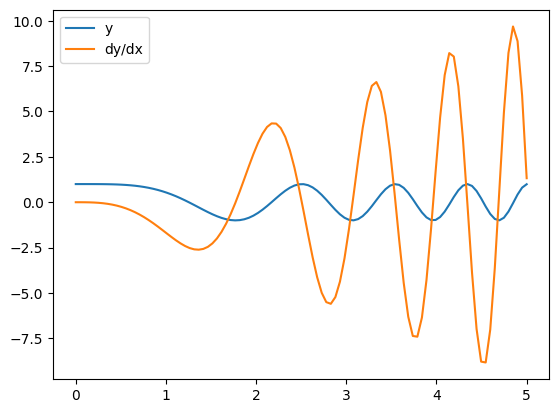

In [ ]:
x = torch.linspace(0, 5, 100,
          requires_grad=True)
y = (x**2).cos()
s = y.sum()
[dydx] = torch.autograd.grad(s, [x])

plt.plot(x.detach(), y.detach(), label='y')
plt.plot(x.detach(), dydx, label='dy/dx')
plt.legend()
plt.show()

(Note that in the example above, because the components of the vector space are independent of each other, we happen to have `dy[j] / dx[i] == 0` when `j != i`, so that `d(y.sum())/dx[i] = dy[i]/dx[i]`.  That means computing a single gradient vector of the sum `s` is equiavlent to computing elementwise derivatives `dy/dx`.)

**Detaching tensors from the computation history.** Every tensor that depends on `x` will be `requires_grad=True` and connected to the complete computation history. But if you were to convert a tensor to a regular python number, pytorch would not be able to see the calculations and would not be able to compute gradients on it.

To avoid programming mistakes where some computation invisibly goes through a non-pytorch number that cannot be tracked, pytorch disables requires-grad tensors from being converted to untrackable numbers.  You need to explicitly call `x.detach()` or `y.detach()` first, to explicitly say that you want an untracked reference, before plotting the data or using it as non-pytorch numbers.

### Exercise

Plot the polynomial y=x<sup>3</sup>-6x<sup>2</sup>+8x and its derivative, instead of cos(x<sup>2</sup>).

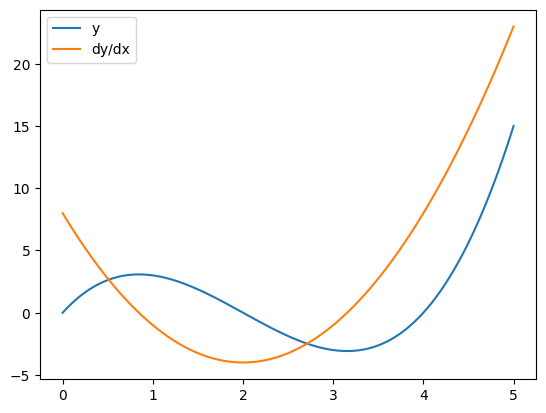

In [ ]:
# TODO: set y to the given polynomial of x
x = torch.linspace(0, 5, 100,
          requires_grad=True)
y = x**3 - 6*x**2 + 8*x

# TODO: use autograd to compute the derivative
s = y.sum()
[dydx] = torch.autograd.grad(s, [x])

# TODO: plot the results.
plt.plot(x.detach(), y.detach(), label='y')
plt.plot(x.detach(), dydx, label='dy/dx')
plt.legend()
plt.show()

Backprop and In-place gradients
-------------------------------

In a typical neural network we will not just be getting gradients with regard to one input like `x` above, but with regard to a list of dozens or hundreds of tensor parameters that have all been marked with `requires_grad=True`.  It can be inconvenient to keep track of which gradient outputs go with which original tensor input.  But since the gradients have exactly the same shape as the inputs, it is natural to store computed gradients in-place on the tensors themselves.

**Using `backward()` to add `.grad` attributes.** To simplify this common operation, pytorch provides the `y.backward()` method, which computes the gradients of y with respect to every tracked dependency, and stores the results in the field `x.grad` for every original input vector `x` that was marked as `requires_grad=True`.

tensor([-0.0000e+00, -2.5765e-04, -2.0612e-03, -6.9560e-03, -1.6485e-02,
        -3.2185e-02, -5.5575e-02, -8.8145e-02, -1.3133e-01, -1.8650e-01,
        -2.5487e-01, -3.3752e-01, -4.3528e-01, -5.4869e-01, -6.7791e-01,
        -8.2262e-01, -9.8193e-01, -1.1543e+00, -1.3373e+00, -1.5279e+00,
        -1.7218e+00, -1.9138e+00, -2.0978e+00, -2.2665e+00, -2.4118e+00,
        -2.5246e+00, -2.5954e+00, -2.6144e+00, -2.5720e+00, -2.4592e+00,
        -2.2684e+00, -1.9940e+00, -1.6330e+00, -1.1861e+00, -6.5843e-01,
        -5.9786e-02,  5.9438e-01,  1.2829e+00,  1.9791e+00,  2.6508e+00,
         3.2620e+00,  3.7737e+00,  4.1467e+00,  4.3434e+00,  4.3315e+00,
         4.0872e+00,  3.5983e+00,  2.8676e+00,  1.9159e+00,  7.8273e-01,
        -4.7262e-01, -1.7729e+00, -3.0265e+00, -4.1327e+00, -4.9894e+00,
        -5.5028e+00, -5.5970e+00, -5.2252e+00, -4.3782e+00, -3.0925e+00,
        -1.4526e+00,  4.1007e-01,  2.3249e+00,  4.0956e+00,  5.5192e+00,
         6.4094e+00,  6.6222e+00,  6.0798e+00,  4.7

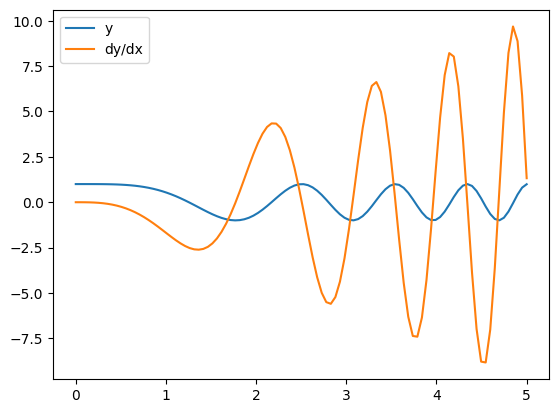

In [ ]:
x = torch.linspace(0, 5, 100, requires_grad=True)
y = (x**2).cos()
y.sum().backward()   # populates the grad attribute below.
print(x.grad)

plt.plot(x.detach(), y.detach(), label='y')
plt.plot(x.detach(), x.grad, label='dy/dx')
plt.legend()
plt.show()

Accumulating and Zeroing grad
-----------------------------

**Gradient accumulation.** If you find that your data batches are too large to get gradients of the
whole thing, then it is usually possible to split the batches into smaller pieces and add the
gradients. Because gradient accumulation is a common pattern, if you call `.backward()` when parameters
`x.grad` already exists, it is not an error.  The new gradient will be *added* to the old one.

**zero_grad().** That means that you need to set any previous value of `x.grad` to zero before
running `backward()`, or else the new gradient will be added to the old one.  Optimizers have a
utility `optim.zero_grad()` to do this to all the optimized parameters at once.

Saving memory on inference
--------------------------

**Avoid autograd when you don't need it.** Normally, all the parameters of a neural network are set to `requires_grad=True` by default, so they are ready to be trained.  But that means that whenever you run a network, you will get output which is also requires-grad, and it will be attached to a long computation history that consumes a lot of precious GPU memory.

To avoid all this expense when you have no intention of training the network, you could go through all the network parameters to set `requires_grad=False`.

Another way to avoid the computation history is to enclose the entire computation within a `with torch.no_grad():` block.  This will suppress all the autograd mechanics (which means, of course, `.backward()` will not function).

**Note that this is different from the role of `net.eval()` which puts puts the network in inference mode computationally (batchnorm, dropout, and other operations behave differently in training and inference); `net.eval()` does not have any effect on `requires_grad`.**

In [ ]:
#@title Run this cell to setup visualization...
# This cell defines plot_progress() which plots an optimization trace.

import matplotlib
from matplotlib import pyplot as plt

def plot_progress(bowl, track, losses):
    # Draw the contours of the objective function, and x, and y
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))
    for size in torch.linspace(0.1, 1.0, 10):
        angle = torch.linspace(0, 6.3, 100)
        circle = torch.stack([angle.sin(), angle.cos()])
        ellipse = torch.mm(torch.inverse(bowl), circle) * size
        ax1.plot(ellipse[0,:], ellipse[1,:], color='skyblue')
    track = torch.stack(track).t()
    ax1.set_title('progress of x')
    ax1.plot(track[0,:], track[1,:], marker='o')
    ax1.set_ylim(-1, 1)
    ax1.set_xlim(-1.6, 1.6)
    ax1.set_ylabel('x[1]')
    ax1.set_xlabel('x[0]')
    ax2.set_title('progress of y')
    ax2.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    ax2.plot(range(len(losses)), losses, marker='o')
    ax2.set_ylabel('objective')
    ax2.set_xlabel('iteration')
    fig.show()

from IPython.display import HTML
HTML('''<script>function toggle_code(){$('.rendered.selected div.input').toggle().find('textarea').focus();} $(toggle_code())</script>
<a href="javascript:toggle_code()">Toggle</a> the code for plot_progress.''')

Pytorch Optimizers
==================

Optimizers have a simple job: given gradients of an objective with respect to a set of input parameters, adjust the parameters reduce the objective.  They do this by modifying each parameter by a small amount in the direction given by the gradient.


Gradient descent just subtracts the gradient
---------
You can apply gradient descent by hand easily by just using `loss.backward()` to compute the gradient of the loss with respect to every parameter `x`, and then apply `x -= learning_rate * x.grad` to nudge `x` in the gradient direction that makes the loss smaller.

Here is an example of applying gradient descent by hand:

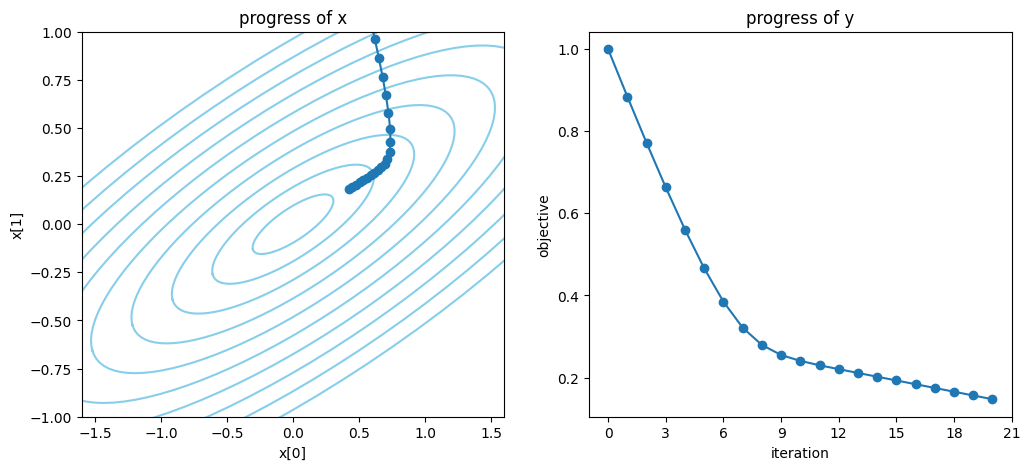

In [ ]:
import torch

x_init = torch.randn(2)
x = x_init.clone()

bowl = torch.tensor([[ 0.4410, -1.0317], [-0.2844, -0.1035]])
track, losses = [], []

for iter in range(21):
    x.requires_grad = True
    loss = torch.mm(bowl, x[:,None]).norm()
    loss.backward()
    with torch.no_grad():
        x = x - 0.1 * x.grad
    track.append(x.detach().clone())
    losses.append(loss.detach())

plot_progress(bowl, track, losses)

Built-in optimization algorithms
------

Pytorch includes several optimization algorithms.

The actual optmization algorithms employ a number of techniques to make the process faster and more robust as repeated steps are taken, by trying to adapt to the shape of the objective surface as it is explored.  The simplest method is SGD-with-momentum, which is implemented in pytorch as `pytorch.optim.SGD`.

Using SGD
---------

To use SGD, you need to calculate your objective and fill in gradients on all the parameters before it can take a step.

  1. Set your parameters (x in this case) to `x.requires_grad = True` so autograd tracks them (line 5).
  2. Create the optimizer and tell it about the parameters to adjust (`[x]` here) (line 6).
  3. In a loop, compute your objective, then call `loss.backward()` to fill in `x.grad` and then `optimizer.step()` to adjust `x` accordingly (lines 12-15).
  
**Remember to zero gradient.** Notice that we use `optimizer.zero_grad()` each time to set x.grad to zero before recomputing gradients; if we do not do this, then the new gradient will be added to the old one.


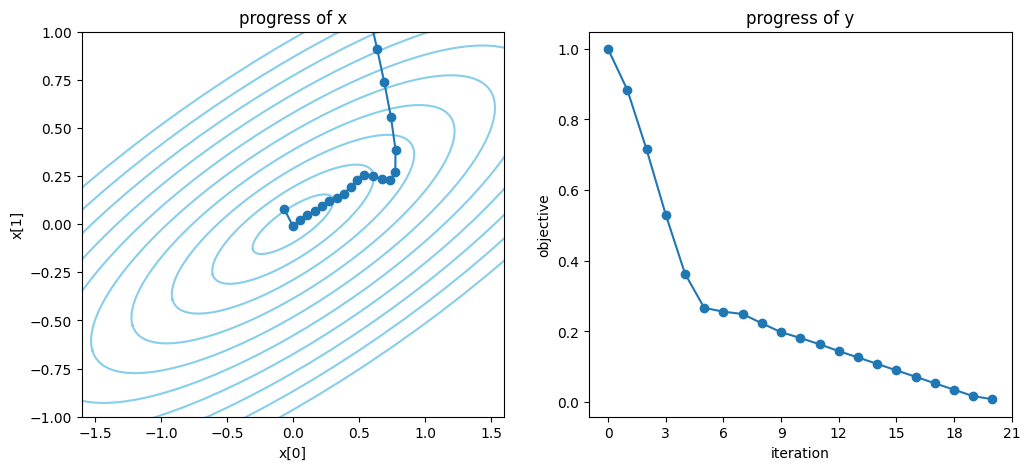

In [ ]:
import torch

x = x_init.clone()
x.requires_grad = True
optimizer = torch.optim.SGD([x], lr=0.1, momentum=0.5)

bowl = torch.tensor([[ 0.4410, -1.0317], [-0.2844, -0.1035]])
track, losses = [], []

for iter in range(21):
    loss = torch.mm(bowl, x[:,None]).norm()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    track.append(x.detach().clone())
    losses.append(loss.detach())

plot_progress(bowl, track, losses)

Using other optimizers
----------------------

Other optimizers are similar.  Adam is a popular adaptive method that does well without much tuning, and can be dropped in to replace plain SGD.

Some other fancy optimizers, such as LBFGS, need to be given an objective function that they can call repeatedly to probe gradients themselves.  Examples can be found elsewhere: for example [hjmshi's LBFGS includes some examples](https://github.com/hjmshi/PyTorch-LBFGS/blob/master/examples/Other/lbfgs_tests.py#L129-L132).

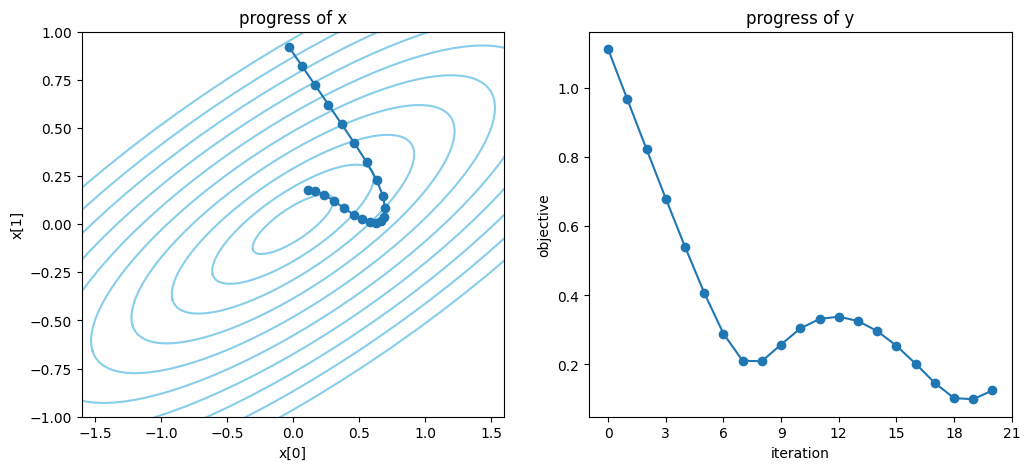

In [ ]:
# The code below uses Adam
x = x_init.clone()
x.requires_grad = True
optimizer = torch.optim.Adam([x], lr=0.1)

track, losses = [], []

for iter in range(21):
    loss = torch.mm(bowl, x[:,None]).norm()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    track.append(x.detach().clone())
    losses.append(loss.detach())

plot_progress(bowl, track, losses)

Other tricks
------------------------

 1. **Learning rate schedules**.  One of the simplest and most effective ways to improve training is to adjust the learning rate, decreasing it during training.   There are many differerent strategies for scheduling learning rates, and pytorch comes with a set of `torch.optim.lr_scheduler` classes to make it easy to drop in a variety of methods.  See [Stack overflow](https://stackoverflow.com/questions/48324152/) or [scheduler documentation](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR).
 2. **Multiple optimizers**. Sometimes you want to optimize more than one objective.  The ordinary solution to this is to make an single overall objective as a (weighted) sum of all the objectives.  However, sometimes you want to apply one objective to some parameters and a different objective to a different set of parameters.  This occurs, for example in *adversarial training* such as in GANs, where two networks are learning to play against each other.  In this case you can use multiple different optimizers, one for each opposing objective.  See [Examples of GAN implementations](https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py#L112-L113) to see how this is done.

Pytorch Neural Network Modules
==============================

Pytorch uses the `torch.nn.Module` class to represent a neural network.

A `Module` is just a **callable** function that can be:

 * **Parameterized** by trainable `Parameter` tensors that the module can list out.
 * **Composed** out of children `Module`s that contribute parameters.
 * **Saved and Loaded** by listing named parameters and other attribute buffers.

Pytorch comes with several built-in elementary network modules, like a generic single-layer `Linear` network, or a generic `Sequential` composition of other networks, but of course you can write your own `Module` subclasses by just defining `Parameter` attributes and using them to implement a computation.

To see how every `Module` manages its own portion of responsibilities of all the network duties above, we first look at how to use the built-in `Linear` and `Sequential` modules.

Using torch.nn.Linear as a Neural Network
=========================================

The linear layer is not just a good starting example: it is the fundmental workhorse of all neural networks, so as simple as it is, it is worth examining carefully.

`torch.nn.Linear` implements the function `y = Ax + b`, which takes m-dimensional input `x` and produces n-dimensional output `y`, by multiplying by the n &times; m matrix `A` (whose specific values are called the `weight`) and adding n-dimensional vector `b` (whose values are called the `bias`).  We can make a Linear network with 3d input and 2d output just like this:

In [ ]:
net = torch.nn.Linear(3, 2)
print(net)

Linear(in_features=3, out_features=2, bias=True)


Like any Module, our little network can be run as a function.  As expected, when we give it 3-d vector as input, we get a 2-d vector as output.

In [ ]:

x = torch.tensor([[1.0, 0.0, 0.0]])
net(x) # wx+b

tensor([[0.4542, 0.1257]], grad_fn=<AddmmBackward0>)

**Batchwise processing is assumed in pytorch networks.** Notice the double nesting in the vector data above.  This is needed because our `Linear`  network is slightly different from a plain matrix-vector multiplication. By convention, pytorch `Module`s are set up to process data in batches, so to give it a single 3-d vector, instead of passing just a vector, we have passed it a singleton batch containing one vector.

We can instead send in several inputs - here we provide four vectors as inputs.  The network then gives us four vectors as outputs:

In [ ]:
x_batch = torch.tensor([
    [1.0, 0. , 0. ],
    [0. , 1.0, 0. ],
    [0. , 0. , 1.0],
    [0. , 0. , 0. ],
])
print(x_batch.shape)
net(x_batch)

torch.Size([4, 3])


tensor([[ 0.4542,  0.1257],
        [ 0.0472,  0.6130],
        [ 0.2370, -0.4331],
        [ 0.4416,  0.0492]], grad_fn=<AddmmBackward0>)

**Parameters are randomly initializated by default.** What strange function is this Linear layer computing?  By default pytorch has initialized the weights and bias randomly.  We can look at these random parameters directly.

There are inbuild functionalities to initialize layers using custom distributions such as normal or uniform. More information on weight initialization can be found [here](https://pytorch.org/docs/stable/nn.init.html)

In [ ]:
print('weight is', net.weight)
print('bias is', net.bias)

weight is Parameter containing:
tensor([[ 0.0126, -0.3944, -0.2046],
        [ 0.0765,  0.5638, -0.4823]], requires_grad=True)
bias is Parameter containing:
tensor([0.4416, 0.0492], requires_grad=True)


### Exercise

1. Set the `bias` of the network to the zero vector.
2. Examine the numerical results of `net(x_batch)`.  Do the answers match the parameters as you would expect?

**Hint**: although `x.zero_()` or `x[:] = 0.0` can zero a vector in place, since the network parameters are all `requires_grad=True`, you will need to put things in a `with torch.no_grad()` block to temporarily disable autograd before changing the values.

In [ ]:
# TODO: Set the bias of the network to the zero vector.
with torch.no_grad():
  net.bias[:] = 0
# TODO: Compare the numerical results of net(x_batch) to the parameters.
print(net(x_batch))

tensor([[-0.5172,  0.5339],
        [ 0.3973,  0.4088],
        [-0.0243,  0.0053],
        [ 0.0000,  0.0000]], grad_fn=<AddmmBackward0>)


**Parameters are set up for autograd and optimization, and can be listed out.**  Above you can see that both the weight and the bias are trainable parameters, because they both have the `Parameter` type.  The tensors also both marked as `requires_grad=True`, which means they are marked to participate in autograd and optimization for training.

These are the only two trainable parameters of the network.  To check this, we can list all parameters by name, using `net.named_parameters()`.

In [ ]:
for name, param in net.named_parameters():
    print(f'{name} = {param}\n')

weight = Parameter containing:
tensor([[ 0.0126, -0.3944, -0.2046],
        [ 0.0765,  0.5638, -0.4823]], requires_grad=True)

bias = Parameter containing:
tensor([0.4416, 0.0492], requires_grad=True)



**A Module can be saved by saving its state_dict.**   `net.state_dict()` is similar to `net.named_parameters()` but it returns a detached reference to the data (that is, `requires_grad=False`) so the data can be saved directly.  Also, for more complicated modules, `state_dict()` may include other non-trainable attributes that are needed to save the network's state.

In [ ]:
for k, v in net.state_dict().items():
    print(f'{k}: {v.type()}{tuple(v.shape)}')

import os
os.makedirs('checkpoints', exist_ok=True)
torch.save(net.state_dict(), 'checkpoints/linear.pth')

weight: torch.FloatTensor(2, 3)
bias: torch.FloatTensor(2,)


**load_state_dict() can be used to reload a saved Module.**  Pytorch also comes with convenient `torch.save` and `torch.load` functions for saving state dicts to files.

In [ ]:
# Then later, to remember the state
net.load_state_dict(torch.load('checkpoints/linear.pth'))

<ipython-input-38-a295d3448eca>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('checkpoints/linear.pth'))


<All keys matched successfully>

Training Example: Optimizing a Linear Layer
-------------------------------------------

To train a network we need to come up with a score for how close we are to the goal.  This scalar number is called the **objective** or the **loss**.

For example, suppose we would like this network to always output `[1, 1]` regardless of input.  Then a reasonable loss would be the mean squared distance to `[1, 1]`, computed like this:

In [ ]:
y_batch = net(x_batch)
loss = ((y_batch - torch.tensor([[1.0, 1.0]])) ** 2).sum(1).mean()
print(f'loss is {loss}')

loss is 1.492878794670105


We can use autograd get gradients to see how small changes in every parameter would impact the loss.

In [ ]:
loss.backward()
print(f'weight is {net.weight} and grad is:\n{net.weight.grad}\n')
print(f'bias is {net.bias} and grad is:\n{net.bias.grad}\n')

weight is Parameter containing:
tensor([[ 0.0126, -0.3944, -0.2046],
        [ 0.0765,  0.5638, -0.4823]], requires_grad=True) and grad is:
tensor([[-0.2729, -0.4764, -0.3815],
        [-0.4371, -0.1935, -0.7165]])

bias is Parameter containing:
tensor([0.4416, 0.0492], requires_grad=True) and grad is:
tensor([-1.4100, -1.8226])



**Simple gradient descent can be done directly.**  To improve our layer, we can use simple gradient descent with a learning rate of 0.01.  That is, we can adjust each parameter by subtracting 0.01 times the gradient.  If we do this repeatedly, we should get closer to our objective.

Any time we directly update the network parameters, we need to temporarily disable the autograd machinery using `with torch.no_grad()`.

weight is Parameter containing:
tensor([[7.1351e-06, 7.1352e-06, 7.1348e-06],
        [6.9485e-06, 6.9485e-06, 6.9485e-06]], requires_grad=True)

bias is Parameter containing:
tensor([1.0000, 1.0000], requires_grad=True)



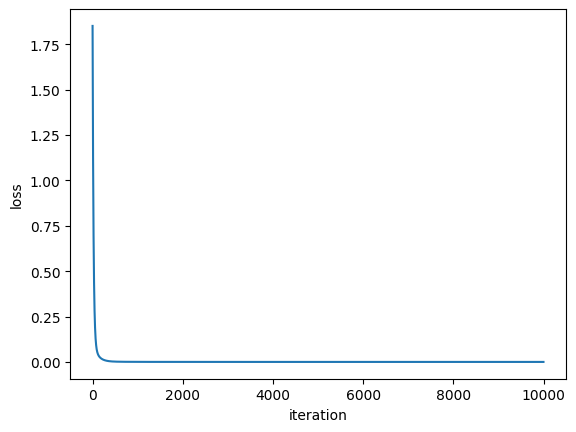

In [ ]:
net = torch.nn.Linear(3, 2)
log = []
for _ in range(10000):
    y_batch = net(x_batch)
    loss = ((y_batch - torch.tensor([[1.0, 1.0]])) ** 2).sum(1).mean()
    log.append(loss.item())
    net.zero_grad()
    loss.backward()
    with torch.no_grad():
        for p in net.parameters():
            p[...] -= 0.01 * p.grad
print(f'weight is {net.weight}\n')
print(f'bias is {net.bias}\n')

%matplotlib inline
import matplotlib.pyplot as plt
plt.ylabel('loss')
plt.xlabel('iteration')
plt.plot(log)
plt.show()

Voila, we have trained a simple neural network to our desired objective of outputting a constant ones vector.  After a few thousand updates, the weight has a near-zero matrix, and the bias becomes `[1.0, 1.0]`, as desired.

**A realistic training loop would run on the GPU using bigger batches of randomized input and a prepackaged optimization algorithm.**

Below we create a newly randomized `Linear` net instance, and train it on the GPU using the Adam optimizer fo 1000 iterations.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

weight is Parameter containing:
tensor([[-2.5821e-09, -6.5335e-09, -1.0826e-08],
        [-4.2034e-08, -2.2271e-08, -1.3659e-08]], requires_grad=True)

bias is Parameter containing:
tensor([1.0000, 1.0000], requires_grad=True)



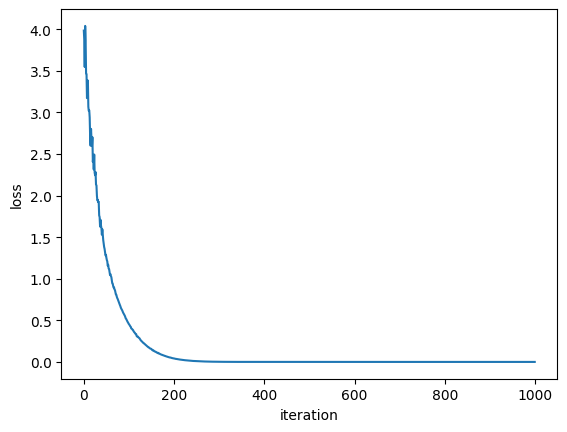

In [ ]:
from torch.optim import Adam
net = torch.nn.Linear(3, 2)
optimizer = Adam(net.parameters(), lr=0.01)
# Move the network, target value, and training inputs to the GPU
net.to(device)
target = torch.tensor([[1.0, 1.0]], device=device)
log = []
for _ in range(1000):
    y_batch = net(torch.randn(100, 3, device=device))
    loss = ((y_batch - target) ** 2).sum(1).mean()
    log.append(loss.item())
    net.zero_grad()
    loss.backward()
    optimizer.step()
print(f'weight is {net.weight}\n')
print(f'bias is {net.bias}\n')

%matplotlib inline
import matplotlib.pyplot as plt
plt.ylabel('loss')
plt.xlabel('iteration')
plt.plot(log)

In [ ]:
# This visulaization function is used for the next example

%matplotlib inline
from matplotlib import pyplot as plt

def visualize_net(net, classify_target):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    grid = torch.stack([
        torch.linspace(-2, 2, 100)[None, :].expand(100, 100),
        torch.linspace(2, -2, 100)[:, None].expand(100, 100),
    ])
    x, y = grid
    target = classify_target(x, y)
    ax1.set_title('target')
    ax1.imshow(target.float(), cmap='hot', extent=[-2,2,-2,2])
    ax2.set_title('network output')
    score = net(grid.permute(1, 2, 0).reshape(-1, 2).to(device)).softmax(1)
    ax2.imshow(score[:,1].reshape(100, 100).detach().cpu(), cmap='hot', extent=[-2,2,-2,2])
    plt.show()

from IPython.display import HTML
HTML('''<script>function toggle_code(){$('.rendered.selected div.input').toggle().find('textarea').focus();} $(toggle_code)</script>
<a href="javascript:toggle_code()">Toggle</a> the code for visualize_net.''')

Using torch.nn.Sequential to Compose Networks
---------------------------------------------

Unlike `Linear`, most networks are made by composing many smaller networks.  The simplest way to do this is chain networks together end-to-end, connecting each output to the next input.  For example we can simply compose `Linear` layers.

**Defining a Multilayer Perceptron.** Of course, to get something more interesting than another linear function, we need to do something nonlinear between the linear steps.  if we add a nonlinearity between each step (for example, if we clamp negative numbers to zero - an operation called `ReLU`), then we can get a **Multilayer Perceptron,** which is known to be a universal function approximator, i.e., a family of piecewise-linear functions that can approximate any function.


Here is how we can express the network as a nested set of Sequentials.

In [ ]:
from collections import OrderedDict
from torch.nn import Linear, ReLU, Sequential

mlp = torch.nn.Sequential(OrderedDict([
    ('layer1', Sequential(Linear(2, 20), ReLU())),
    ('layer2', Sequential(Linear(20, 20), ReLU())),
    ('layer3', Sequential(Linear(20, 2)))
]))

print(mlp)
# You could also define the forward pass through the forward() function of nn.Module (Later in the colab)

Sequential(
  (layer1): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=20, out_features=2, bias=True)
  )
)


In the above, we have nested two levels of Sequentials.  In the outermost level, we have defined and named three layers.

Then each layer is itself a Sequential that executes a parameterized `Linear` operation followed by a `ReLU` nonlinear clamping operation.  We have not bothered to name each of the innermost steps, so the Sequential just automatically numbers them.

**Every submodule has a fully qualified name.** We can get a full recursive list of submodules by listing `net.named_modules()`.

In [ ]:
for n, c in mlp.named_modules():
    print(f'{n or "The whole network"} is a {type(c).__name__}')

The whole network is a Sequential
layer1 is a Sequential
layer1.0 is a Linear
layer1.1 is a ReLU
layer2 is a Sequential
layer2.0 is a Linear
layer2.1 is a ReLU
layer3 is a Sequential
layer3.0 is a Linear


**A module's parameters include all its child module parameters.** We can see this by listing all the parameters by name.    

In [ ]:
for name, param in mlp.named_parameters():
    print(f'{name} has shape {tuple(param.shape)}')

layer1.0.weight has shape (20, 2)
layer1.0.bias has shape (20,)
layer2.0.weight has shape (20, 20)
layer2.0.bias has shape (20,)
layer3.0.weight has shape (2, 20)
layer3.0.bias has shape (2,)


There are now six parameters: a weight and a bias for each of the three `Linear` layers.

**Training a Clasifier.** This slightly more complicated network can now represent a more general class of functions. For example, we can use this architecture to learn to compute a classifier function.  

Suppose we want to classify points on a plane as either above a sine-wave (class 1) or below a sine-wave (class 0). Here is the ordinary training loop to train our MLP to do it, using the Adam optimizer:


Iteration 0 accuracy: 0.6439999938011169


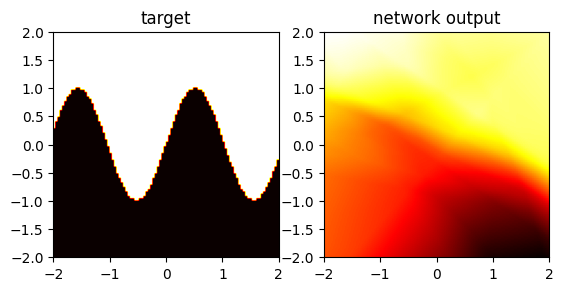

Iteration 1 accuracy: 0.6419000029563904


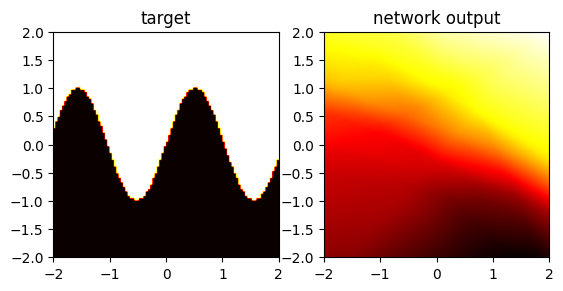

Iteration 3 accuracy: 0.7394000291824341


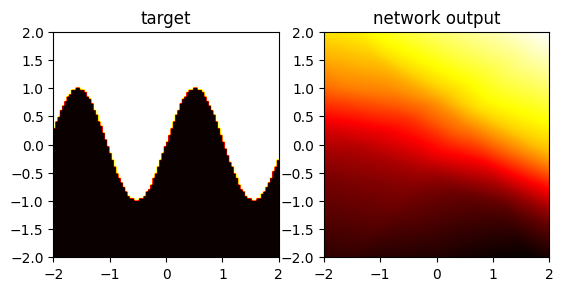

Iteration 7 accuracy: 0.7580000162124634


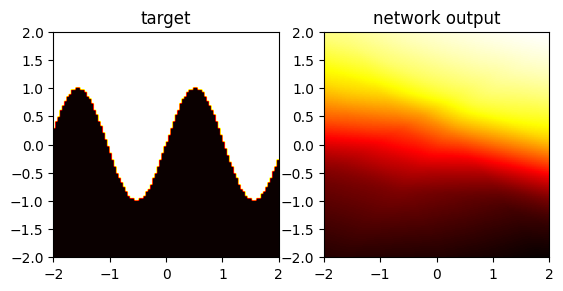

Iteration 15 accuracy: 0.7651000022888184


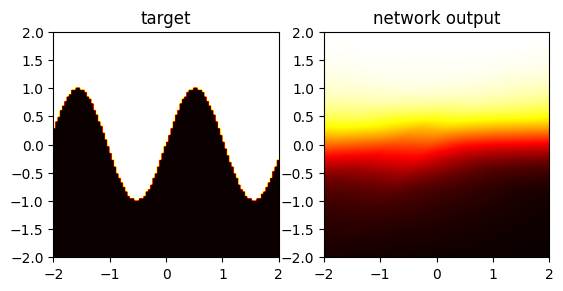

Iteration 31 accuracy: 0.8093000054359436


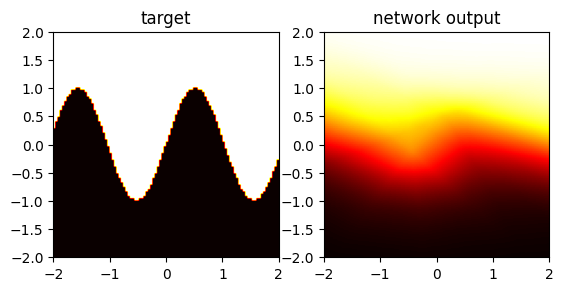

Iteration 63 accuracy: 0.910099983215332


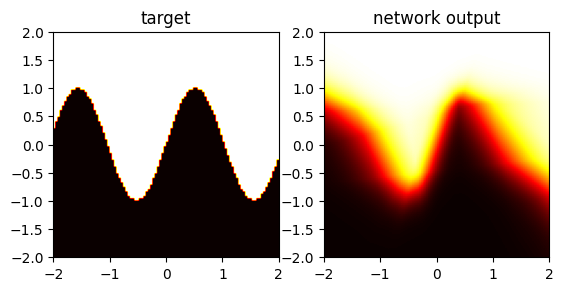

Iteration 127 accuracy: 0.9754999876022339


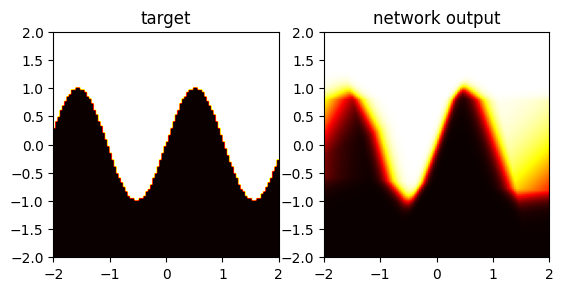

Iteration 255 accuracy: 0.9847000241279602


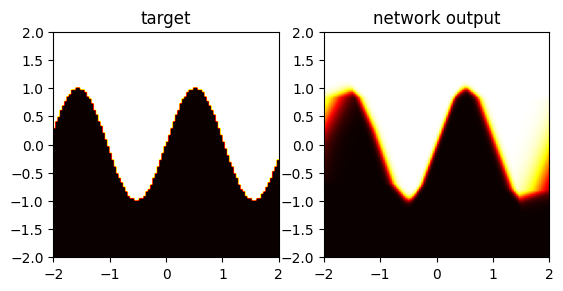

Iteration 511 accuracy: 0.991100013256073


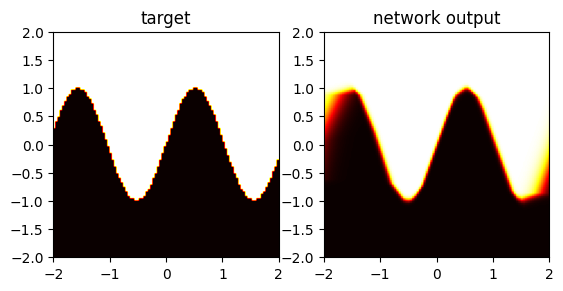

Iteration 1023 accuracy: 0.9886999726295471


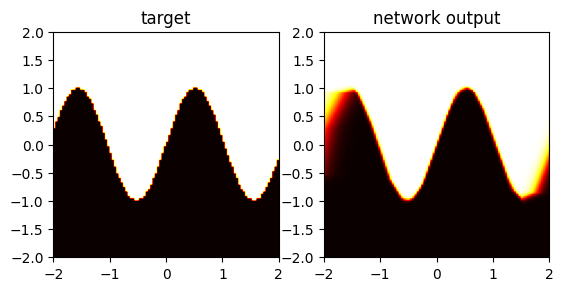

In [ ]:
device = 'cpu'
from torch.nn.functional import cross_entropy

def classify_target(x, y):
    return (y > (x * 3).sin()).long()

mlp.to(device)
optimizer = Adam(mlp.parameters(), lr=0.01)
for iteration in range(1024):
    in_batch = torch.randn(10000, 2, device=device)
    target_batch = classify_target(in_batch[:,0], in_batch[:,1])
    out_batch = mlp(in_batch)
    loss = cross_entropy(out_batch, target_batch)
    if iteration > 0:
        mlp.zero_grad()
        loss.backward()
        optimizer.step()
    if iteration == 2 ** iteration.bit_length() - 1:
        pred_batch = out_batch.max(1)[1]
        accuracy = (pred_batch == target_batch).float().sum() / len(in_batch)
        print(f'Iteration {iteration} accuracy: {accuracy}')
        visualize_net(mlp, classify_target)


**A network can be saved by saving its state_dict.**  Since the state_dict gathers together all the parameters of the submodules, we can save it all at once.  Note that since every parameter is given a fully-qualified name, if we wanted to load just a subset of the layers, we could do that by picking out keys of the dictionary and adjusting their names by hand.

In [ ]:
for k, v in mlp.state_dict().items():
    print(f'{k}: {v.dtype}{tuple(v.shape)}')

torch.save(mlp.state_dict(), 'checkpoints/mlp.pth')


layer1.0.weight: torch.float32(20, 2)
layer1.0.bias: torch.float32(20,)
layer2.0.weight: torch.float32(20, 20)
layer2.0.bias: torch.float32(20,)
layer3.0.weight: torch.float32(2, 20)
layer3.0.bias: torch.float32(2,)


Defining `forward` to Create Custom Networks
--------------------------------

Sometimes you will want to hook up network components in a more complicated way than just a sequential operation of predefined components.

For example, [ResNet](https://arxiv.org/abs/1512.03385) is built on the observation that learning can work much better if, instead of learning an arbitrary linear operation, we learn perturbations of the identity.  I.e., have a layer learn to compute a small residual instead of the whole total answer.

To apply the residual trick in our little three-layer network, we cannot just use an overall `Sequential`: instead we will define the operation by writing our own `forward` function.  It looks like this:

In [ ]:
class MyNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = Sequential(Linear(2, 20), ReLU())
        self.residual_layer2 = Sequential(Linear(20, 20), ReLU())
        self.layer3 = Linear(20, 2)

    def forward(self, x):
        x = self.layer1(x)
        x = x + self.residual_layer2(x)
        x = self.layer3(x)
        return x

res_mlp = MyNetwork()
print(res_mlp)

# Exercise left to you: try training res_mlp just like we trained mlp above.

MyNetwork(
  (layer1): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): ReLU()
  )
  (residual_layer2): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU()
  )
  (layer3): Linear(in_features=20, out_features=2, bias=True)
)


Training the network above can be done exactly the same way as training our previous `Sequential` mlp.  Try copying+pasting the training code and adapting it to this new network.

Iteration 0 accuracy: 0.5130000114440918


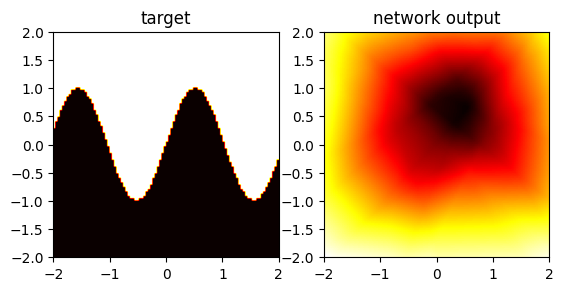

Iteration 1 accuracy: 0.5098999738693237


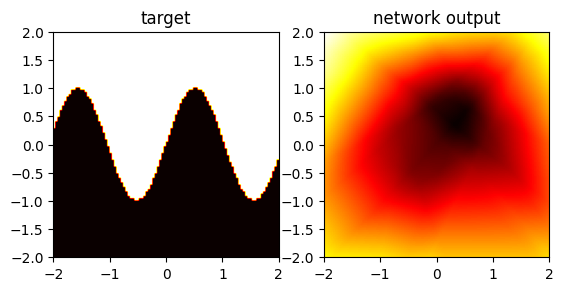

Iteration 3 accuracy: 0.5379999876022339


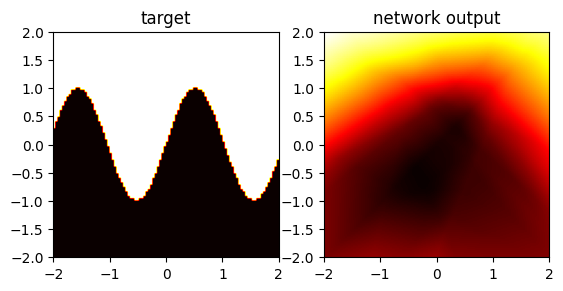

Iteration 7 accuracy: 0.7748000025749207


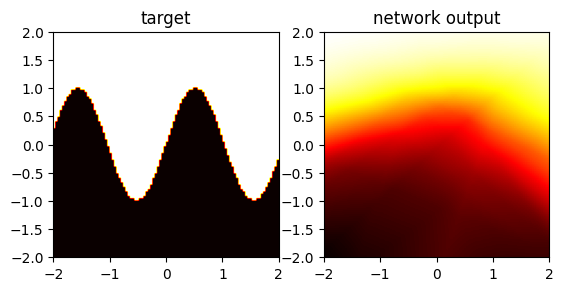

Iteration 15 accuracy: 0.7833999991416931


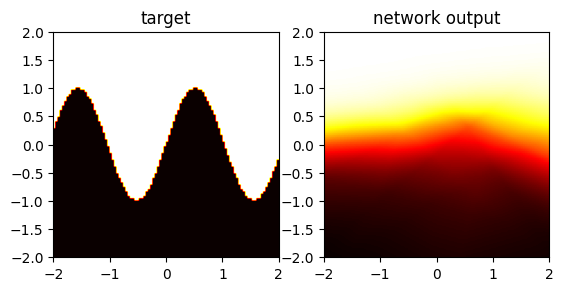

Iteration 31 accuracy: 0.8248999714851379


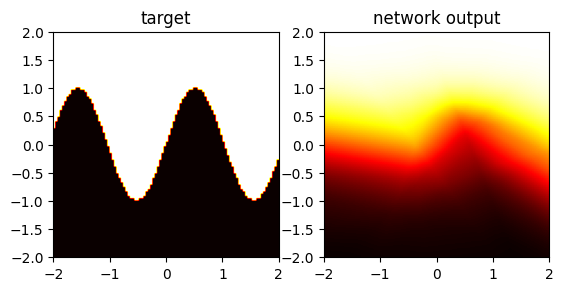

Iteration 63 accuracy: 0.9121999740600586


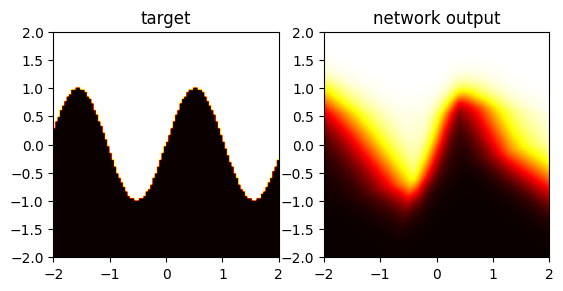

Iteration 127 accuracy: 0.9696999788284302


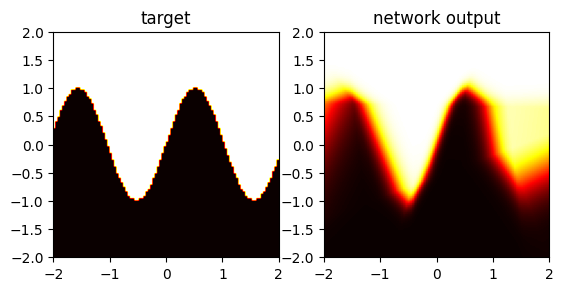

Iteration 255 accuracy: 0.9855999946594238


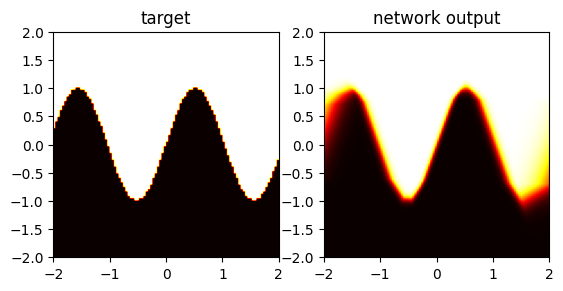

Iteration 511 accuracy: 0.9878000020980835


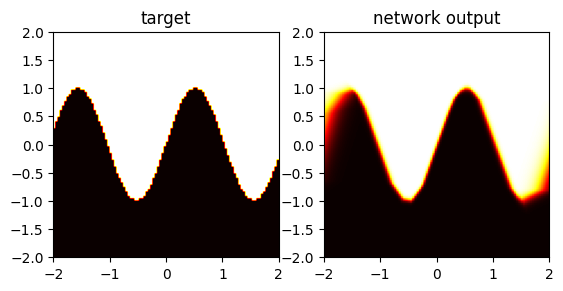

Iteration 1023 accuracy: 0.9932000041007996


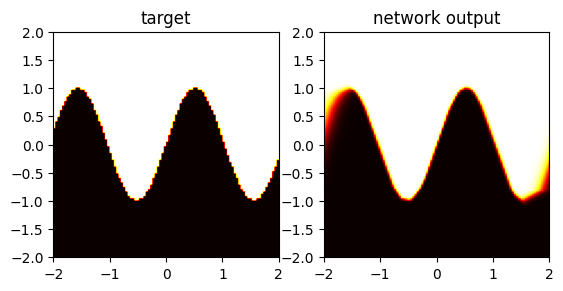

In [ ]:
def classify_target(x, y):
    return (y > (x * 3).sin()).long()

res_mlp.to(device)
optimizer = Adam(res_mlp.parameters(), lr=0.01)
for iteration in range(1024):
    in_batch = torch.randn(10000, 2, device=device)
    target_batch = classify_target(in_batch[:,0], in_batch[:,1])
    out_batch = res_mlp(in_batch)
    loss = cross_entropy(out_batch, target_batch)
    if iteration > 0:
        res_mlp.zero_grad()
        loss.backward()
        optimizer.step()
    if iteration == 2 ** iteration.bit_length() - 1:
        pred_batch = out_batch.max(1)[1]
        accuracy = (pred_batch == target_batch).float().sum() / len(in_batch)
        print(f'Iteration {iteration} accuracy: {accuracy}')
        visualize_net(res_mlp, classify_target)

## Other `Module` tricks

 * **torch.nn.Parameter** wraps trainable parameters. In the `__init__()` method, you can define more tensors as parameters to be optimized, by wrapping parameter tensors with a `torch.nn.Parameter` before setting the attribute.  See the [pytorch Linear source code](https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py#L74-L78) to see an example.  (In that code, the `in_features` and `out_features` attributes are just ordinary numbers that are not trainable, but `weight` and `bias` are wrapped in `Parameter` objects to mark them as trainable tensors.)
 * **module.training** allows special behavior during training. Some modules behave differently at training time than at inference time.  For example, a [Dropout](http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf) layer will drop half the channels and amplify the other half randomly during training, but at inference, for better performance, it will include all the channels. To support this sort of trick, there is a `module.train()` method to put a module (recursively) into training mode and a `module.eval()` to put it into inference mode.  The `module.training` boolean tells which mode is current.  See the [pytorch dropout source code](https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/dropout.py#L24-L58) to see the `training` flag in use.
 * **buffers** can be learned without the optimizer.  Not every attribute of a module needs to be trainable by the optimizer.  Some attributes can be learned in a different way, for example, by observing and averaging statistics observed during training time.  The most famous example of this is the [Batchnorm](https://arxiv.org/abs/1502.03167) layer, which observes mean and variance during training, and accumulates statistics to enforces zero mean and unit variance.  See the pytorch [batchnorm module source code](https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/batchnorm.py#L27-L55) for an example of using **buffers** which are not optimized by the optimizer.
 * **Predefined model architectures** are available; for example, `torchvision.models.resnet18(num_classes=100)` will create a ResNet-18 classifier model, configured to do a 100-way classification of images.  See [torchvision.models documentation](https://pytorch.org/docs/stable/torchvision/models.html) for the standard torchvision model zoo.

Datasets & DataLoaders
======================

Code for processing data samples can get messy and hard to maintain; we
ideally want our dataset code to be decoupled from our model training
code for better readability and modularity. PyTorch provides two data
primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset`
that allow you to use pre-loaded datasets as well as your own data.
`Dataset` stores the samples and their corresponding labels, and
`DataLoader` wraps an iterable around the `Dataset` to enable easy
access to the samples.

PyTorch domain libraries provide a number of pre-loaded datasets (such
as FashionMNIST) that subclass `torch.utils.data.Dataset` and implement
functions specific to the particular data. They can be used to prototype
and benchmark your model. You can find them here: [Image
Datasets](https://pytorch.org/vision/stable/datasets.html), [Text
Datasets](https://pytorch.org/text/stable/datasets.html), and [Audio
Datasets](https://pytorch.org/audio/stable/datasets.html)


Loading a Dataset
=================

Here is an example of how to load the
[Fashion-MNIST](https://research.zalando.com/project/fashion_mnist/fashion_mnist/)
dataset from TorchVision. Fashion-MNIST is a dataset of Zalando's
article images consisting of 60,000 training examples and 10,000 test
examples. Each example comprises a 28×28 grayscale image and an
associated label from one of 10 classes.

We load the [FashionMNIST Dataset](https://pytorch.org/vision/stable/datasets.html#fashion-mnist) with the following parameters:

:   -   `root` is the path where the train/test data is stored,
    -   `train` specifies training or test dataset,
    -   `download=True` downloads the data from the internet if it\'s
        not available at `root`.
    -   `transform` and `target_transform` specify the feature and label
        transformations


In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:00<00:00, 39974172.21it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 6065700.55it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 10595805.76it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 3027520.61it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Iterating and Visualizing the Dataset
=====================================

We can index `Datasets` manually like a list: `training_data[index]`. We
use `matplotlib` to visualize some samples in our training data.


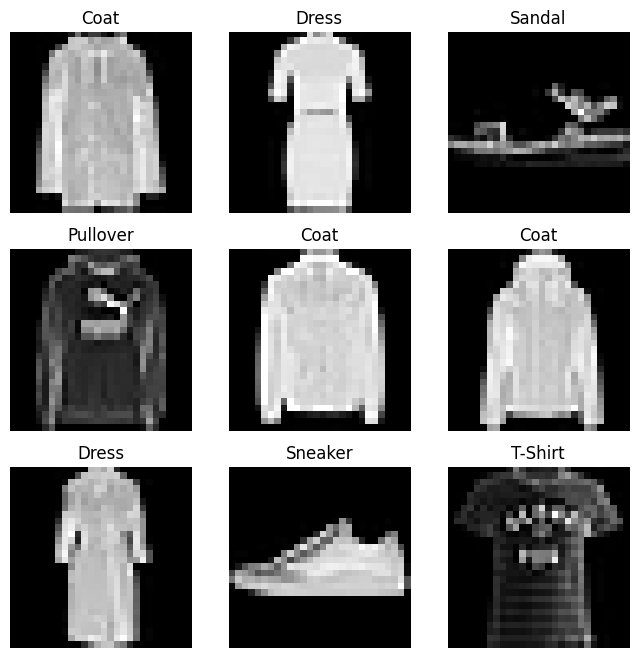

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


Creating a Custom Dataset for your files
========================================

A custom Dataset class must implement three functions:
[\_\_init\_\_]{.title-ref}, [\_\_len\_\_]{.title-ref}, and
[\_\_getitem\_\_]{.title-ref}. Take a look at this implementation; the
FashionMNIST images are stored in a directory `img_dir`, and their
labels are stored separately in a CSV file `annotations_file`.


`__init__`
==========

The `__init__` function is run once when instantiating the Dataset
object. We initialize the directory containing the images, the
annotations file, and both transforms (covered in more detail in the
next section).

The labels.csv file looks like: :

    tshirt1.jpg, 0
    tshirt2.jpg, 0
    ......
    ankleboot999.jpg, 9

`__len__`
=========

The `__len__` function returns the number of samples in our dataset.


`__getitem__`
=============

The `__getitem__` function loads and returns a sample from the dataset
at the given index `idx`. Based on the index, it identifies the image\'s
location on disk, converts that to a tensor using `read_image`,
retrieves the corresponding label from the csv data in
`self.img_labels`, calls the transform functions on them (if
applicable), and returns the tensor image and corresponding label in a
tuple.


In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Preparing your data for training with DataLoaders
=================================================

The `Dataset` retrieves our dataset\'s features and labels one sample at
a time. While training a model, we typically want to pass samples in
\"minibatches\", reshuffle the data at every epoch to reduce model
overfitting, and use Python\'s `multiprocessing` to speed up data
retrieval.

`DataLoader` is an iterable that abstracts this complexity for us in an
easy API.


In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Iterate through the DataLoader
==============================

We have loaded that dataset into the `DataLoader` and can iterate
through the dataset as needed. Each iteration below returns a batch of
`train_features` and `train_labels` (containing `batch_size=64` features
and labels respectively). Because we specified `shuffle=True`, after we
iterate over all batches the data is shuffled (for finer-grained control
over the data loading order, take a look at
[Samplers](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler)).


Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


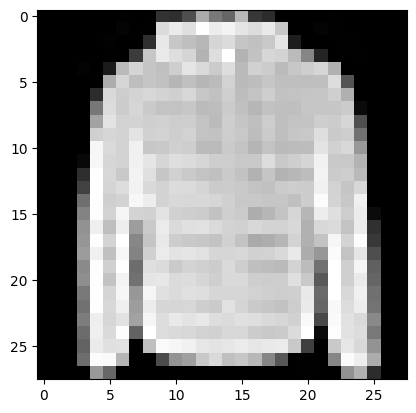

Label: 4


In [ ]:
# Display image and label.

for train_features, train_labels in train_dataloader:
  print(f"Feature batch shape: {train_features.size()}")
  print(f"Labels batch shape: {train_labels.size()}")
  img = train_features[0].squeeze()
  label = train_labels[0]
  plt.imshow(img, cmap="gray")
  plt.show()
  print(f"Label: {label}")
  break